## CIA - 2 (SHREYA R SRINIVASAN - 21011101122)

### Question:

Consider the image formation model given by
g = Af + n, where g is the observed image, f is the ground truth and n is additive noise. 
Get an estimate for f using 
- Wiener filter 
- using MAP estimation and 
- any deep network based approach under the following cases.

Case (i): A is an identity matrix and n is Gaussian noise. ( the denoising problem)

Case(II): A is a matrix derived out of assuming some camera shake. For solutions using MAP and deep network based approach assume that A is unknown ( A blind deconvolution problem).

### Import necessary libraries and read the image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from math import log10, sqrt
from scipy.optimize import minimize
from scipy.signal import convolve2d
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Input

In [2]:
original_img = cv2.imread('flower.jpg')

In [3]:
gray_image = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

In [4]:
original_img.shape, gray_image.shape
# original_img -> 3 channels
# gray_image -> 1 channel

((224, 225, 3), (224, 225))

In [10]:
gray_image[:1]

array([[16, 19, 21, 21, 19, 17, 17, 18, 13, 13, 13, 13, 11,  9,  6,  5,
         9, 11, 15, 19, 21, 21, 20, 18, 47, 56, 67, 76, 77, 71, 61, 53,
        54, 56, 60, 65, 71, 76, 80, 83, 77, 81, 83, 78, 67, 59, 56, 56,
        64, 77, 91, 93, 81, 66, 55, 50, 70, 69, 68, 65, 63, 61, 59, 58,
        51, 55, 61, 66, 69, 69, 67, 66, 66, 66, 66, 66, 66, 66, 66, 66,
        68, 68, 67, 66, 65, 64, 63, 63, 66, 66, 66, 67, 67, 68, 68, 68,
        68, 68, 67, 66, 65, 64, 63, 63, 64, 64, 65, 65, 66, 66, 66, 67,
        68, 68, 69, 69, 69, 70, 70, 70, 72, 72, 71, 71, 70, 70, 70, 69,
        67, 68, 69, 72, 74, 76, 78, 79, 89, 87, 83, 78, 73, 68, 64, 62,
        65, 65, 64, 63, 63, 62, 61, 61, 57, 54, 50, 45, 42, 41, 42, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44,
        44, 44, 44, 44, 43, 43, 42, 42, 43, 39, 37, 40, 46, 49, 46, 43,
        43, 43, 42, 41, 40, 39, 39, 38, 36, 36, 36, 36, 36, 36, 36, 36,
        38, 46, 57, 62, 63, 65, 69, 74, 70, 49, 34, 36, 41, 38, 

In [11]:
gray_image.min(), gray_image.max()

(1, 230)

In [12]:
original_img.min(), original_img.max()

(0, 255)

### PSNR

Peak Signal-to-Noise Ratio is an expression for the ratio of signal power to noise power
- PSNR = 10 log(R^2/ MSE)
- R = 255

In [4]:
def PSNR(original, distorted): 
    mse = np.mean((original - distorted)**2)
    if mse == 0: # no noise
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

### Apply Gaussian Noise - Case (i)

- Generate Gaussian noise
- Add the noise to the image
-  Ensure the pixel values are within the valid range (0-255)
- Convert back to uint8
-  Display the noisy image


In [5]:
mean = 0
variance = 50
gaussian = np.random.normal(mean, variance, gray_image.shape)

In [16]:
gaussian.shape

(224, 225)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-202.9018399 , -197.68558454, -192.46932918, -187.25307382,
        -182.03681846, -176.8205631 , -171.60430774, -166.38805238,
        -161.17179702, -155.95554166, -150.7392863 , -145.52303094,
        -140.30677558, -135.09052022, -129.87426486, -124.6580095 ,
        -119.44175413, -114.22549877, -109.00924341, -103.79298805,
         -98.57673269,  -93.36047733,  -88.14422197,  -82.92796661,
         -77.71171125,  -72.49545589,  -67.27920053,  -62.06294517,
         -56.84668981,  -51.63043445,  -46.41417909,  -41.19792373,
         -35.98166837,  -30.76541301,  -25.54915765,  -20.33290229,
         -15.11664693,   -9.90039157,   -4.68413621,    0.53211915,
           5.74837451,   10.96462987,   16.18088523,   21.39714059,
   

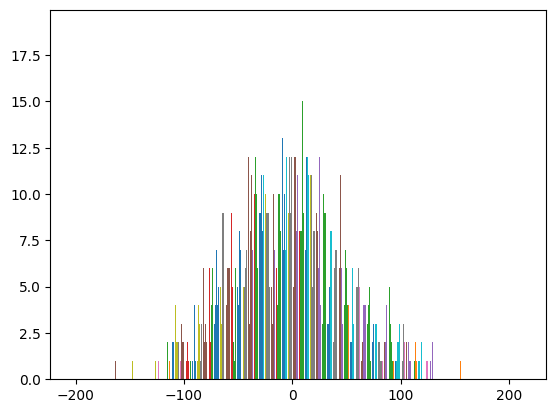

In [21]:
plt.hist(gaussian, bins=80) # we can observe a gaussian distribution

In [ ]:
xmin, xmax = plt.xlim() # gets the current x-axis limits of the matplotlib plot 
# print(xmin, xmax) # 0.0 1.0
x = np.linspace(xmin, xmax, 100) # This line generates an array of 100 evenly spaced values between xmin and xmax inclusive.
# print(x[:10])

In [57]:
p = (1 / (np.sqrt(2 * np.pi * variance))) * np.exp(-(x - mean)**2 / (2 * variance)) 
'''
This line of code is calculating the probability density function (PDF) of a normal (Gaussian) distribution 
with a given mean and variance for the values in the array x.
'''

'\nThis line of code is calculating the probability density function (PDF) of a normal (Gaussian) distribution \nwith a given mean and variance for the values in the array x.\n'

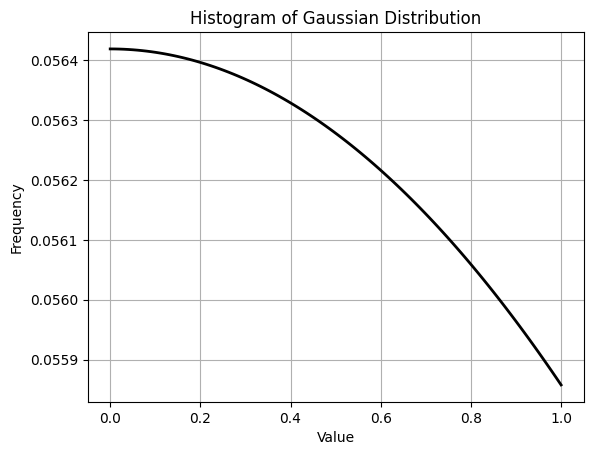

In [26]:
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Gaussian Distribution')
plt.grid(True)
plt.show()

In [6]:
noisy_image_01 = gray_image + gaussian

In [49]:
noisy_image_01.min(), noisy_image_01.max()

(-153.17721970154938, 390.81456462373365)

In [7]:
noisy_image_01 = np.clip(noisy_image_01, 0, 255) # clips (limits) the values in the array to be between 0 and 255

In [51]:
noisy_image_01[:5]

array([[ 13.23493535,  47.93130227,  37.42996381, ...,  20.91266374,
         68.4660795 ,  16.13205998],
       [  0.        ,  15.64180751,  12.55651433, ..., 107.31081999,
        178.74809788,   0.        ],
       [ 55.9377827 ,  35.92137743,  29.85481644, ...,  91.20466441,
          0.        ,   3.25088601],
       [  0.        ,   0.        ,  80.39950577, ...,   0.        ,
         56.94147718,   0.        ],
       [114.38482899,   0.        ,   5.09606166, ...,   0.        ,
          0.        ,   0.        ]])

In [8]:
noisy_image_01 = np.uint8(noisy_image_01) # converts the array from float to unsigned 8-bit integers

In [53]:
noisy_image_01[:5]

array([[ 13,  47,  37, ...,  20,  68,  16],
       [  0,  15,  12, ..., 107, 178,   0],
       [ 55,  35,  29, ...,  91,   0,   3],
       [  0,   0,  80, ...,   0,  56,   0],
       [114,   0,   5, ...,   0,   0,   0]], dtype=uint8)

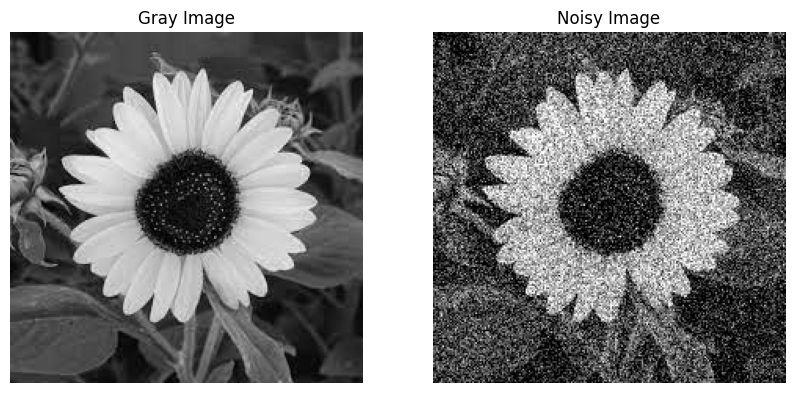

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(gray_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Gray Image')

axes[1].imshow(noisy_image_01, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Noisy Image')

plt.show()

In [55]:
print("PSNR of Gray Image and Noisy Image: ", PSNR(gray_image, noisy_image_01))

PSNR of Gray Image and Noisy Image:  27.965674990688612


### `Wiener Filter`

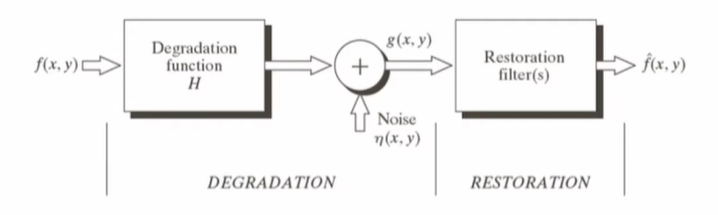

- Wiener filtering was one of the first methods developed to reduce additive random noise in images. 
- It works on the assumption that additive noise is a stationary random process, independent of pixel location. (Noise and image are uncorrelated)
- The algorithm minimizes the square error between the original and reconstructed images.

    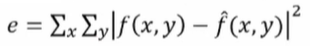
    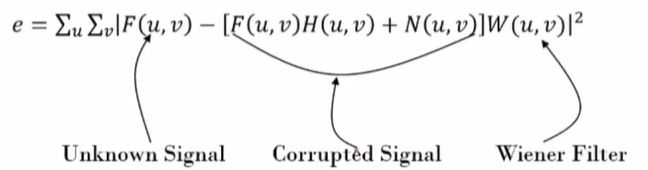

- Wiener filtering is a low-pass filter, but instead of having a single cutoff frequency, it is a space-varying filter designed to use a low cutoff in low-detail regions and a high cutoff to retain detail in regions with edges or other high-variance features. 
- The window size determines the overall frequency cutoff: larger windows correspond to lower cutoff frequencies, and therefore more blurring and noise reduction.

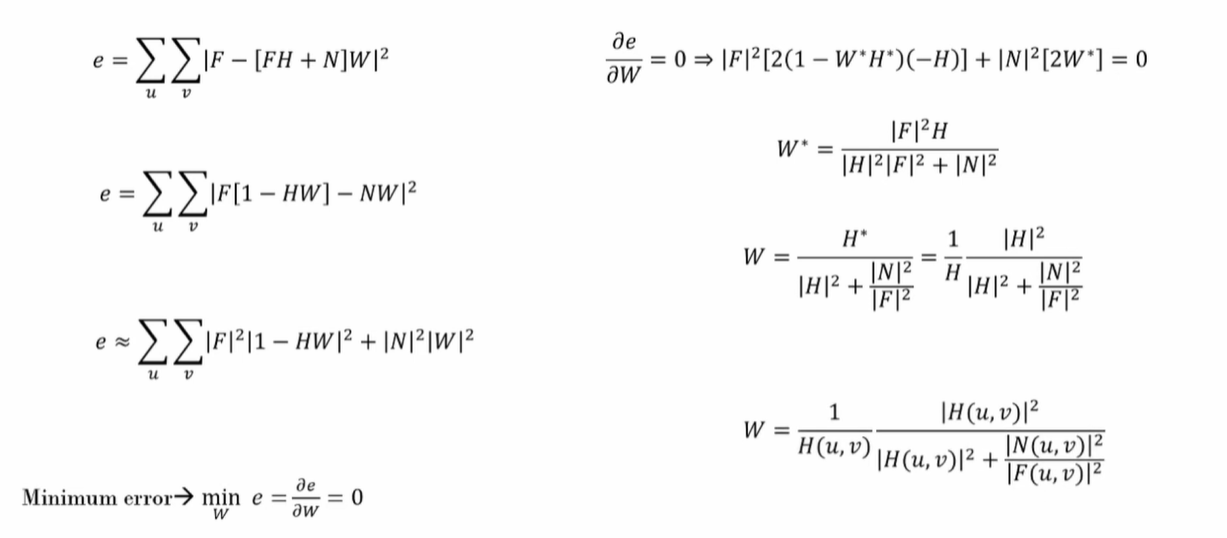

In [9]:
wiener_filtered_01 = wiener(noisy_image_01, (3, 3), variance) # apply Wiener filter to the noisy image with a 3x3 kernel 

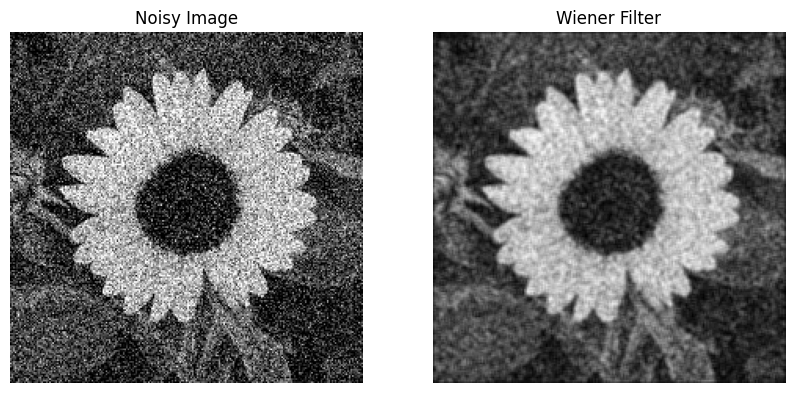

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(noisy_image_01, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Noisy Image')

axes[1].imshow(wiener_filtered_01, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Wiener Filter')

plt.show()

In [11]:
print("PSNR of Original Image and Wiener Filtered Image: ", PSNR(gray_image, wiener_filtered_01))

PSNR of Original Image and Wiener Filtered Image:  22.62201559265515


### `MAP Estimation`

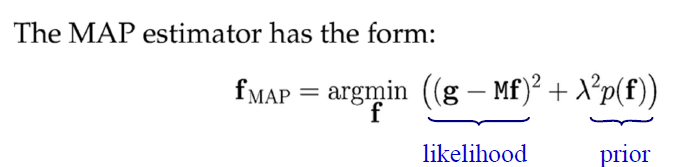

In [12]:
def map_restore(og_img, kernel, nlevel, iters):
    temp_img = og_img.copy()
    for _ in range(iters):
        blur_estimate = convolve2d(temp_img, kernel, mode='same', boundary='wrap') 
        # This line estimates the blur in the image by convolving f_img with a blur kernel. 
        # The 'same' mode means the output will be the same size as f_img, and the 'wrap' boundary option means that the input is assumed to be periodic.
        
        data_likelihood = np.exp(-0.5 * ((og_img - blur_estimate) / nlevel) ** 2) 
        # This line calculates the data likelihood, which is the probability of the observed image given the estimated image and the noise level.
        
        prior_likelihood = np.ones_like(temp_img)  
        # Uniform prior -> we assume all possible images are equally likely, sets up a matrix of ones with the same shape as temp_img
        
        posterior = data_likelihood * prior_likelihood
        temp_img = posterior / np.sum(posterior) # normalize the posterior
    
    return 1 - temp_img # returns the negative of the estimated image. This is done to invert the colors of the image

In [13]:
kernel = np.ones((5, 5)) / 25
'''
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]
'''
map_estimation_01 = map_restore(noisy_image_01, kernel, 100, 100)

In [14]:
print("PSNR of Original Image and MAP Estimated Image: ", PSNR(gray_image, map_estimation_01))

PSNR of Original Image and MAP Estimated Image:  7.371728060818841


### `CNN`

In [15]:
model = Sequential([
    Input(shape=(224, 225, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(224 * 225, activation='linear')
])

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Reshape input
noisy_image_01_reshaped = noisy_image_01.reshape((1, 224, 225, 1))

# Train the model
history = model.fit(noisy_image_01_reshaped, gray_image.reshape((1, 224 * 225)), epochs=10, verbose=0)

# Predict/denoise noisy_image_01
denoised_image_01 = model.predict(noisy_image_01_reshaped).reshape((224, 225))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


In [17]:
print("PSNR of Original Image and MAP Estimated Image: ", PSNR(gray_image, denoised_image_01))

PSNR of Original Image and MAP Estimated Image:  7.891528560466071


### Apply Motion Blur - Case (ii)

In [18]:
kernel_size = 20
kernel_v = np.zeros((kernel_size, kernel_size)) 
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
kernel_v /= kernel_size 
noisy_image_02 = cv2.filter2D(noisy_image_01, -1, kernel_v) 

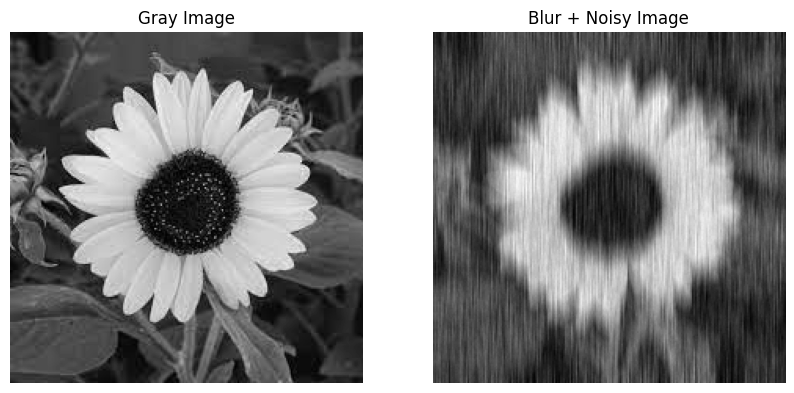

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(gray_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Gray Image')

axes[1].imshow(noisy_image_02, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Blur + Noisy Image')

plt.show()

In [20]:
print("PSNR of Gray Image and Blur + Noisy Image: ", PSNR(gray_image, noisy_image_02))

PSNR of Gray Image and Blur + Noisy Image:  28.69944705792665


### `Wiener Filter`

In [21]:
wiener_filtered_02 = wiener(noisy_image_02, (5, 5), variance)

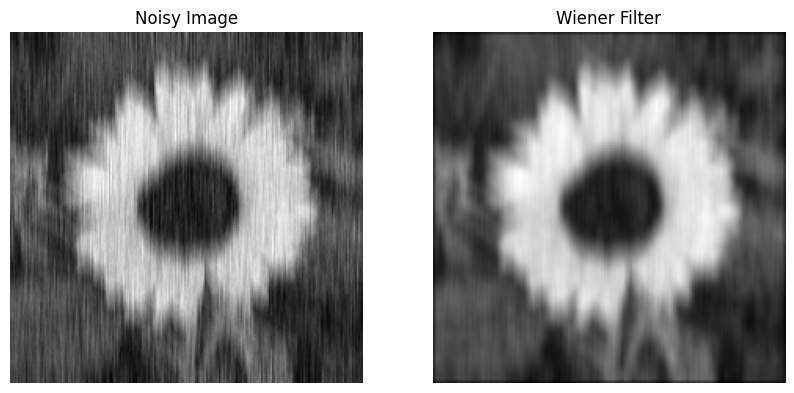

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(noisy_image_02, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Noisy Image')

axes[1].imshow(wiener_filtered_02, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Wiener Filter')

plt.show()

In [22]:
print("PSNR of Original and Wiener Filtered Image: ", PSNR(gray_image, wiener_filtered_02))

PSNR of Original and Wiener Filtered Image:  20.10083017265969


### `MAP Estimation`

In [23]:
kernel = np.ones((5, 5)) / 25
map_estimation_02 = map_restore(noisy_image_02, kernel, 100, 100)

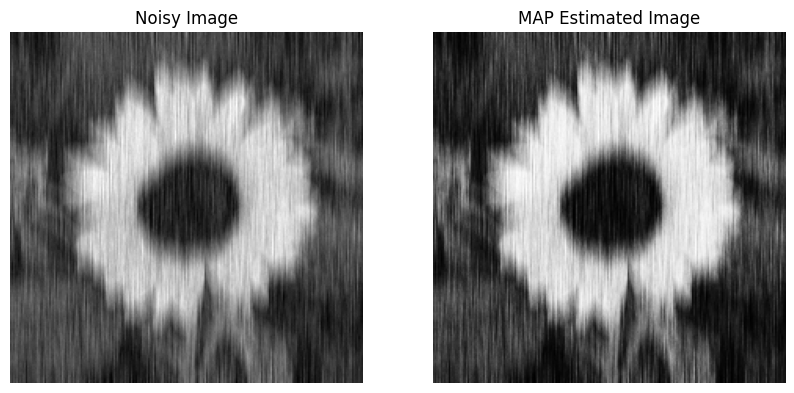

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(noisy_image_02, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Noisy Image')

axes[1].imshow(map_estimation_02, cmap='gray')
axes[1].axis('off')
axes[1].set_title('MAP Estimated Image')

plt.show()

In [24]:
print("PSNR of Otiginal Image and MAP Estimated Image: ", PSNR(gray_image, map_estimation_02))

PSNR of Otiginal Image and MAP Estimated Image:  7.371728035973302


### `CNN`

In [25]:
# Reshape input
noisy_image_02_reshaped = noisy_image_02.reshape((1, 224, 225, 1))

# Train the model
history = model.fit(noisy_image_02_reshaped, gray_image.reshape((1, 224 * 225)), epochs=10, verbose=0)

# Predict/denoise noisy_image_02
denoised_image_02 = model.predict(noisy_image_02_reshaped).reshape((224, 225))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [26]:
print("PSNR of Original Image and MAP Estimated Image: ", PSNR(gray_image, denoised_image_02))

PSNR of Original Image and MAP Estimated Image:  16.605541139191942
